In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
training_data = datasets.CIFAR10(root='data', train=True, download=True, transform=ToTensor(),)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor(),)
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, g_map_dim, num_channel = 3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, g_map_dim*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(g_map_dim*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(g_map_dim*8, g_map_dim*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_map_dim*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(g_map_dim*4, g_map_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_map_dim*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(g_map_dim*2, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [6]:
z_dim = 100
g_map_dim = 128

In [7]:
gen = Generator(z_dim, g_map_dim)
gen.to(device)

gen.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, d_map_dim, num_channel = 3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channel, d_map_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(d_map_dim, d_map_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_map_dim*2),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(d_map_dim*2, d_map_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_map_dim*4),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(d_map_dim*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [9]:
d_map_dim = 64
disc = Discriminator(d_map_dim).to(device)

disc.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [10]:
lr = 2e-4
beta1 = 0.5

In [11]:
criterion = nn.BCELoss()

noise = torch.randn(64, z_dim,1, 1, device =device)

real_label = 1
fake_label = 0

optD = optim.Adam(disc.parameters(), lr = lr,  betas=(beta1, 0.999))
optG = optim.Adam(gen.parameters(), lr = lr,  betas=(beta1, 0.999))

In [12]:
epochs = 5
num = len(train_dataloader.dataset)//batch_size
gen_loss, disc_loss = [], []
for epoch in tqdm(range(epochs)):
    g, d = [], []
    for i, (X,y) in tqdm(enumerate(train_dataloader), total = num):
        X = X.to(device)
        disc.zero_grad()
        
        l = torch.full((X.shape[0], ), real_label, dtype = torch.float, device = device)
        output = disc(X).view(-1)
        loss_r = criterion(output, l)
        loss_r.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(X.shape[0], z_dim, 1, 1, device = device)
        fake = gen(noise)
        l.fill_(fake_label)
        output = disc(fake.detach()).view(-1)
        loss_f = criterion(output, l)
        loss_f.backward()
        
        optD.step()
        err_d = loss_r + loss_f
        d.append(err_d.item())
        
        gen.zero_grad()
        l.fill_(real_label)
        output = disc(fake).view(-1)
        l_g = criterion(output, l)
        l_g.backward()
        optG.step()
        g.append(l_g.item())
    gen_loss.append(sum(g)/num)
    disc_loss.append(sum(d)/num)
    
    print(f"[{epoch}] Generator Loss : {gen_loss[-1]:>.5f} Discriminator Loss : {disc_loss[-1]:>.5f}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

[0] Generator Loss : 3.02468 Discriminator Loss : 0.86065


  0%|          | 0/390 [00:00<?, ?it/s]

[1] Generator Loss : 1.42496 Discriminator Loss : 1.18067


  0%|          | 0/390 [00:00<?, ?it/s]

[2] Generator Loss : 1.46425 Discriminator Loss : 1.22678


  0%|          | 0/390 [00:00<?, ?it/s]

[3] Generator Loss : 1.33251 Discriminator Loss : 1.19712


  0%|          | 0/390 [00:00<?, ?it/s]

[4] Generator Loss : 1.32699 Discriminator Loss : 1.19695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


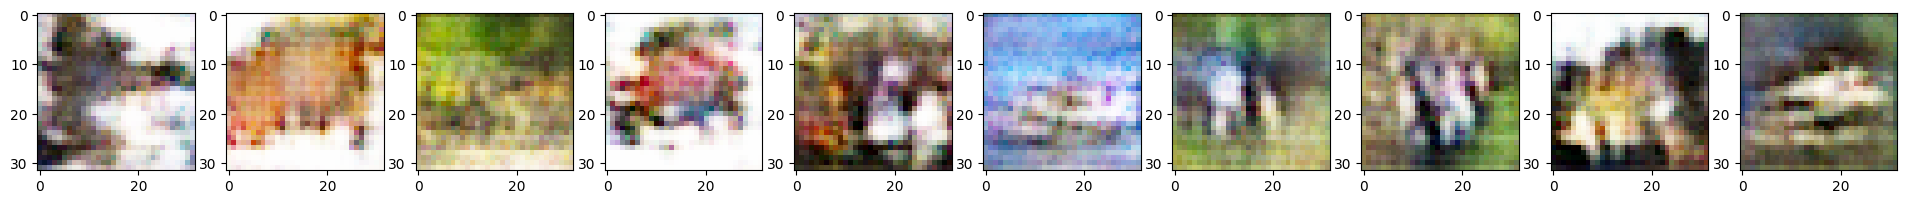

In [13]:
with torch.no_grad():
    fake = gen(torch.randn(10, z_dim, 1, 1, device=device)).detach().cpu()
    fake = np.transpose(fake.numpy(), (0, 2, 3, 1))

_,ax = plt.subplots(1, 10, figsize=(24,4))
for i in range(10):
    ax[i].imshow(fake[i])